# Tabular Playground Series - Nov 2022
  - Practice your ML skills on this approachable dataset!
  - https://www.kaggle.com/competitions/tabular-playground-series-nov-2022

# 0. 패키지

In [1]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. 데이터셋

In [2]:
ds_path = 'datasets/'
subs_path = ds_path + 'submission_files/'

submission_df = pd.read_csv(ds_path + 'sample_submission.csv', index_col='id')
labels_df = pd.read_csv(ds_path + 'train_labels.csv', index_col='id')

sub_ids = submission_df.index
gt_ids = labels_df.index

subs = sorted(os.listdir(ds_path + 'submission_files'))

In [3]:
def read_subs(csv_file_no) :
    return pd.read_csv(subs_path + subs[csv_file_no], index_col='id')

# 2. Torch

## 2.1 전처리

In [5]:
input_size = 5000
bs = 64
rs = 22

In [6]:
class Linear(nn.Module) :
    def __init__(self, input_size) -> None:
        super().__init__()

        self.linear = nn.Linear(input_size+1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) :
        x = self.sigmoid(self.linear(x))

        return x

In [7]:
def make_origin_df(input_size) :
    df = labels_df.copy()

    for i in tqdm(range(input_size)) :
        df = df.join(read_subs(i), on='id', how='outer', rsuffix='_{}'.format(i))

    return df.set_index('id', drop=False)

In [8]:
origin_df = make_origin_df(input_size)

100%|██████████| 5000/5000 [1:35:42<00:00,  1.15s/it]


In [161]:
train_df = origin_df.loc[:19999]

train_Y = train_df['label']
train_X = train_df.drop('label', axis=1)

train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.1, random_state=rs)

In [162]:
train_X.shape, train_Y.shape

((18000, 5001), (18000,))

In [9]:
def to_tensor(df) :
    return torch.from_numpy(df.to_numpy()).float()

def convert_train_dataset(train_X, train_Y) :
    return TensorDataset(to_tensor(train_X), to_tensor(train_Y))

In [164]:
train_dataset = convert_train_dataset(train_X, train_Y)
train_dataloader = DataLoader(train_dataset, batch_size=bs, drop_last=True)

val_dataset = convert_train_dataset(val_X, val_Y)
val_dataloader = DataLoader(val_dataset, batch_size=bs)

## 2.2 학습

In [165]:
def train(model, criterion, optimizer, dataloader) :
    model.train()

    total_loss = 0.0
    total = 0

    for i, (inputs, targets) in enumerate(dataloader) :
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()

        optimizer.step()
        total += outputs.size(0)
        total_loss += loss.item()

    avg_loss = total_loss / total

    return avg_loss

def validate(model, criterion, dataloader) :
    model.eval()

    total_loss = 0.0
    total = 0

    with torch.no_grad() :
        for i, (inputs, targets) in enumerate(dataloader) :
            inputs, targets = inputs.to(device), targets.to(device)
    
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
    
            total += outputs.size(0)
            total_loss += loss.item()

    avg_loss = total_loss / total

    return avg_loss

In [166]:
def run(model, criterion, optimizer, epochs, train_loader, val_loader, log=True) :
    train_loss = []
    val_loss = []
    save_loss = float('inf')

    for i in range(epochs) :
        loss = train(model, criterion, optimizer, train_loader)
        train_loss.append(loss)

        if log :
            print('Epoch : {}'.format(i))
            print('Train Loss : {}'.format(loss))

        loss = validate(model, criterion, val_loader)
        val_loss.append(loss)

        if log :
            print('Epoch : {}'.format(i))
            print('Val Loss : {}'.format(loss))

        if loss < save_loss :
            torch.save(model, 'Linear_{}.pt'.format(input_size))
            save_loss = loss

    return train_loss, val_loss

def loss_plot(train_loss, val_loss) :
    pd.DataFrame({'Train' : train_loss, 'Val' : val_loss}).plot(figsize=(8,6))

    plt.show()
    

In [167]:
net = Linear(input_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [168]:
train_loss, val_loss = run(net, criterion, optimizer, 2000, train_dataloader, val_dataloader)

Epoch : 0
Train Loss : 0.03030465092026095
Epoch : 0
Val Loss : 0.009290044784545898
Epoch : 1
Train Loss : 0.010701380133151583
Epoch : 1
Val Loss : 0.00889356404542923
Epoch : 2
Train Loss : 0.010296233349688537
Epoch : 2
Val Loss : 0.009498544186353684
Epoch : 3
Train Loss : 0.010267539433737243
Epoch : 3
Val Loss : 0.009642398461699486
Epoch : 4
Train Loss : 0.010262693044832275
Epoch : 4
Val Loss : 0.009517155915498733
Epoch : 5
Train Loss : 0.010268981295084295
Epoch : 5
Val Loss : 0.009380824506282807
Epoch : 6
Train Loss : 0.010279879592080663
Epoch : 6
Val Loss : 0.009267145097255706
Epoch : 7
Train Loss : 0.010292931902305194
Epoch : 7
Val Loss : 0.009169443249702454
Epoch : 8
Train Loss : 0.010307689253704828
Epoch : 8
Val Loss : 0.009080528795719146
Epoch : 9
Train Loss : 0.010324561083523616
Epoch : 9
Val Loss : 0.0089963970631361
Epoch : 10
Train Loss : 0.010345149321276097
Epoch : 10
Val Loss : 0.008915119662880897
Epoch : 11
Train Loss : 0.01037376366051915
Epoch : 11
V

KeyboardInterrupt: 

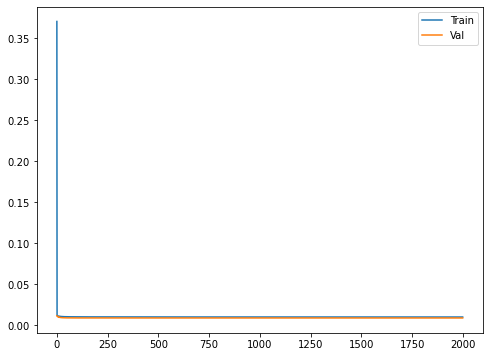

In [ ]:
loss_plot(train_loss, val_loss)

In [14]:
with torch.no_grad() :
    outputs = net(torch.from_numpy(origin_df.loc[:19999].drop('label', axis=1).to_numpy()).float()).squeeze()

log_loss(labels_df, outputs)

0.5300650774925307

## 2.3 추론

### 2.3.1 전처리

In [10]:
input_df = origin_df[20000:].drop('label', axis=1)

input_dataset = TensorDataset(to_tensor(input_df))
input_dataloader = DataLoader(input_dataset)

In [11]:
net = torch.load('Linear_{}.pt'.format(input_size)).to(device)

In [12]:
def prediction(model, input_loader) :
    model.eval()

    preds = []
    with torch.no_grad() :
        for (inputs, ) in tqdm(input_loader) :
            inputs = inputs.to(device)
            
            outputs = model(inputs).squeeze()
            preds.append(outputs.numpy())

    pred_df = pd.DataFrame({'pred' : preds})
    pred_df.index = sub_ids

    return pred_df

### 2.3.2 추론

In [13]:
pred_df = prediction(net, input_dataloader)
pred_df.to_csv('submission_best{}.csv'.format(input_size))

100%|██████████| 20000/20000 [00:07<00:00, 2649.26it/s]


# 3. AutoML

In [1]:
import os
import time
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss

In [ ]:
im